In [ ]:
!git clone https://github.com/lucidrains/denoising-diffusion-pytorch.git

Cloning into 'denoising-diffusion-pytorch'...
remote: Enumerating objects: 1353, done.
remote: Counting objects: 100% (543/543), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 1353 (delta 471), reused 452 (delta 412), pack-reused 810
Receiving objects: 100% (1353/1353), 2.45 MiB | 33.85 MiB/s, done.
Resolving deltas: 100% (989/989), done.


In [ ]:
!pip install einops
!pip install torchdiffeq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.3 MB/s eta 0:00:00


In [ ]:
import os
import shutil

# Source folder path
source_folder = 'denoising-diffusion-pytorch'

# Get a list of all files in the source folder
files = os.listdir(source_folder)

# Move each file to the current folder
for file in files:
    # Construct the source file path
    source_file = os.path.join(source_folder, file)
    # Move the file to the current folder
    shutil.move(source_file, file)

!rm -r denoising-diffusion-pytorch
!rm -r sample_data

In [ ]:
!pip install denoising_diffusion_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 15.2 MB/s eta 0:00:00


In [ ]:
from functools import wraps
from packaging import version
from collections import namedtuple

import torch
import torch.nn as nn
from torch import einsum
import torch.nn.functional as F

from einops import rearrange

# constants

AttentionConfig = namedtuple('AttentionConfig', ['enable_flash', 'enable_math', 'enable_mem_efficient'])

# helpers

def exists(val):
    return val is not None

def once(fn):
    called = False
    @wraps(fn)
    def inner(x):
        nonlocal called
        if called:
            return
        called = True
        return fn(x)
    return inner

print_once = once(print)

# main class

class Attend(nn.Module):
    def __init__(
        self,
        dropout = 0.,
        flash = False
    ):
        super().__init__()
        self.dropout = dropout
        self.attn_dropout = nn.Dropout(dropout)

        self.flash = flash
        assert not (flash and version.parse(torch.__version__) < version.parse('2.0.0')), 'in order to use flash attention, you must be using pytorch 2.0 or above'

        # determine efficient attention configs for cuda and cpu
        self.cpu_config = AttentionConfig(True, True, True)
        self.cuda_config = None

        if not torch.cuda.is_available() or not flash:
            return

        device_properties = torch.cuda.get_device_properties(torch.device('cuda'))

        if device_properties.major == 8 and device_properties.minor == 0:
            print_once('A100 GPU detected, using flash attention if input tensor is on cuda')
            self.cuda_config = AttentionConfig(True, False, False)
        else:
            print_once('Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda')
            self.cuda_config = AttentionConfig(False, True, True)

    def flash_attn(self, q, k, v):
        _, heads, q_len, _, k_len, is_cuda, device = *q.shape, k.shape[-2], q.is_cuda, q.device

        q, k, v = map(lambda t: t.contiguous(), (q, k, v))

        # Check if there is a compatible device for flash attention
        config = self.cuda_config if is_cuda else self.cpu_config

        # pytorch 2.0 flash attn: q, k, v, mask, dropout, causal, softmax_scale
        with torch.backends.cuda.sdp_kernel(**config._asdict()):
            out = F.scaled_dot_product_attention(
                q, k, v,
                dropout_p = self.dropout if self.training else 0.
            )

        return out

    def forward(self, q, k, v):
        """
        einstein notation
        b - batch
        h - heads
        n, i, j - sequence length (base sequence length, source, target)
        d - feature dimension
        """

        q_len, k_len, device = q.shape[-2], k.shape[-2], q.device

        if self.flash:
            return self.flash_attn(q, k, v)

        scale = q.shape[-1] ** -0.5

        # similarity
        sim = einsum(f"b h i d, b h j d -> b h i j", q, k) * scale

        # attention
        attn = sim.softmax(dim = -1)
        attn = self.attn_dropout(attn)

        # aggregate values
        out = einsum(f"b h i j, b h j d -> b h i d", attn, v)

        return out

In [ ]:
import matplotlib.pyplot as plt
import imageio
import einops
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint, odeint_adjoint


MAX_NUM_STEPS = 1000

def sinusoidal_embedding(n, d):
    """
    Generates sinusoidal embeddings for conditioning the model on the current time step.

    Args:
        n (int): The number of time steps.
        d (int): The dimensionality of the embedding.

    Returns:
        torch.Tensor: A tensor of shape (n, d) representing the sinusoidal embeddings.

    """
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:, ::2] = torch.sin(t * wk[:, ::2])
    embedding[:, 1::2] = torch.cos(t * wk[:, ::2])

    return embedding


def _make_te(self, dim_in, dim_out):
    """
    Utility function that creates a one-layer MLP used for mapping a positional embedding.

    Args:
        dim_in (int): The input dimensionality of the MLP.
        dim_out (int): The output dimensionality of the MLP.

    Returns:
        torch.nn.Sequential: A one-layer MLP module.

    """
    return nn.Sequential(
        nn.Linear(dim_in, dim_out),
        nn.SiLU(),
        nn.Linear(dim_out, dim_out)
    )


def get_nonlinearity(name):
    """Helper function to get non linearity module, choose from relu/softplus/swish/lrelu"""
    if name == "relu":
        return nn.ReLU(inplace=True)
    elif name == "softplus":
        return nn.Softplus()
    elif name == "swish":
        return Swish(inplace=True)
    elif name == "lrelu":
        return nn.LeakyReLU()


class Swish(nn.Module):
    def __init__(self, inplace=False):
        """The Swish non linearity function"""
        super().__init__()
        self.inplace = True

    def forward(self, x):
        if self.inplace:
            x.mul_(F.sigmoid(x))
            return x
        else:
            return x * F.sigmoid(x)


class RandomOrLearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with random (learned optional) sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim, is_random = False):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim), requires_grad = not is_random)

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered


class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.g * (x.shape[1] ** 0.5)


class Attention(nn.Module):
    def __init__(
        self,
        dim,
        heads = 4,
        dim_head = 32,
        flash = False
    ):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads

        self.norm = RMSNorm(dim)
        self.attend = Attend(flash = flash)

        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape

        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h (x y) c', h = self.heads), qkv)

        out = self.attend(q, k, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)

        return self.to_out(out)


# class Block(nn.Module):
#     def __init__(self, dim, dim_out, groups = 8):
#         super().__init__()
#         self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
#         # Divides the channels into groups and normalises them
#         self.norm = nn.GroupNorm(groups, dim_out)
#         self.act = nn.SiLU()

#     def forward(self, x, scale_shift = None):
#         x = self.proj(x)
#         x = self.norm(x)

#         # Scales and shifts the output of the normalisation
#         # This allos for additional conditioning of the output
#         if exists(scale_shift):
#             scale, shift = scale_shift
#             x = x * (scale + 1) + shift

#         x = self.act(x)
#         return x


# class ResnetBlock(nn.Module):
#     def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 2):
#         super().__init__()
#         self.mlp = nn.Sequential(
#             nn.SiLU(),
#             nn.Linear(time_emb_dim, dim_out * 2)
#         ) if exists(time_emb_dim) else None

#         self.block1 = Block(dim, dim_out, groups = groups)
#         self.block2 = Block(dim_out, dim_out, groups = groups)
#         # 1x1 convolution used for the residual connection
#         self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

#     def forward(self, x, time_emb = None):

#         scale_shift = None
#         if exists(self.mlp) and exists(time_emb):
#             # Use MLP to compute the scale_shift
#             time_emb = self.mlp(time_emb)
#             time_emb = rearrange(time_emb, 'b c -> b c 1 1')
#             scale_shift = time_emb.chunk(2, dim = 1)

#         # R(x) = H(x) - x => H(x) = R(x) + x
#         h = self.block1(x, scale_shift = scale_shift)
#         h = self.block2(h)

#         # h is the output of the sequence of transformations applied to the input x
#         # self.res_conv(x) is the original input x passed through a 1x1 conv (just to match dims)
#         return h + self.res_conv(x)


class InitialVelocity(nn.Module):
    def __init__(self, nf, non_linearity="relu"):
        super(InitialVelocity, self).__init__()

        self.norm1 = nn.InstanceNorm2d(nf)
        #self.norm1 = nn.InstanceNorm2d(1)
        #self.conv1 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)
        # For 1 channel images (?)
        self.conv1 = nn.Conv2d(3, nf, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.InstanceNorm2d(nf)
        #self.conv2 = nn.Conv2d(nf, nf, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(nf, nf*2, kernel_size=1, stride=1, padding=0)

        self.non_linearity = get_nonlinearity(non_linearity)

    def forward(self, x0):
        out = self.norm1(x0)
        out = self.conv1(out)
        out = self.non_linearity(out)
        out = self.norm2(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        return out #torch.cat((x0, out), dim=1)


class ODEBlock(nn.Module):
    def __init__(self, odefunc, tol=1e-3, adjoint=False):
        """
        Code adapted from https://github.com/EmilienDupont/augmented-neural-odes
        Utility class that wraps odeint and odeint_adjoint.

        Wrapper that takes the function f (given by ConvSODEFunc) and solves the
        ODE using that function. ConvSODEFunc defines the actual transformation of
        the datam while the ODE block is responsible for solving the ODE defined
        by that transformation.

        Args:
            odefunc (nn.Module): the module to be evaluated
            tol (float): tolerance for the ODE solver
            adjoint (bool): whether to use the adjoint method for gradient calculation
        """
        super(ODEBlock, self).__init__()
        self.adjoint = adjoint
        self.odefunc = odefunc
        self.tol = tol

    def forward(self, x, time_emb, eval_times=None, method="rk4"):
        # Forward pass corresponds to solving ODE, so reset number of function
        # evaluations counter
        self.odefunc.nfe = 0

        if eval_times is None:
            integration_time = torch.tensor([0, 1]).float().type_as(x)
        else:
            integration_time = eval_times.type_as(x)

        if self.adjoint:
            out = odeint_adjoint(
                lambda t, x: self.odefunc(t, x, time_emb=time_emb),
                x,
                integration_time,
                rtol=self.tol,
                atol=self.tol,
                method=method,
                options={"max_num_steps": MAX_NUM_STEPS},
            )
        else:
            out = odeint(
                lambda t, x: self.odefunc(t, x, time_emb=time_emb),
                x,
                integration_time,
                rtol=self.tol,
                atol=self.tol,
                method=method,
                options={"max_num_steps": MAX_NUM_STEPS},
            )

        if eval_times is None:
            return out[1]  # out[1][:int(len(x)/2)]  Return only final time
        else:
            return out

    def trajectory(self, x, timesteps):
        integration_time = torch.linspace(0.0, 1.0, timesteps)
        return self.forward(x, eval_times=integration_time)


class Conv2dTime(nn.Conv2d):
    def __init__(self, in_channels, *args, **kwargs):
        """
        Code adapted from https://github.com/EmilienDupont/augmented-neural-odes
        Conv2d module where time gets concatenated as a feature map.
        Makes ODE func aware of the current time step.
        """
        super(Conv2dTime, self).__init__(in_channels + 1, *args, **kwargs)

    def forward(self, t, x):
        # Shape (batch_size, 1, height, width)
        t_img = torch.ones_like(x[:, :1, :, :]) * t
        # Shape (batch_size, channels + 1, height, width)
        t_and_x = torch.cat([t_img, x], 1)
        return super(Conv2dTime, self).forward(t_and_x)


# class ConvSODEFunc(nn.Module):
#     def __init__(self, nf, time_dependent=False, non_linearity="relu"):
#         """
#         Block for ConvSODEUNet. Designed to be used as the function f that defines
#         the derivative in an ODE of the form dz/dt = f(t, z). This function represents
#         how the hidden state z changes with respect to the continuous time variable t.

#         ConvSODE defines the actual transformation of the datam while the ODE
#         block is responsible for solving the ODE defined by that transformation.

#         Args:
#             nf (int): number of filters for the conv layers
#             time_dependent (bool): whether to concat the time as a feature map before the convs
#             non_linearity (str): which non_linearity to use (for options see get_nonlinearity)
#         """
#         super(ConvSODEFunc, self).__init__()
#         self.time_dependent = time_dependent
#         self.nfe = 0  # Number of function evaluations

#         if time_dependent:
#             self.norm1 = nn.InstanceNorm2d(nf)
#             self.conv1 = Conv2dTime(nf, nf, kernel_size=3, stride=1, padding=1)
#             self.norm2 = nn.InstanceNorm2d(nf)
#             self.conv2 = Conv2dTime(nf, nf, kernel_size=3, stride=1, padding=1)
#         else:
#             self.norm1 = nn.InstanceNorm2d(nf)
#             self.conv1 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)
#             self.norm2 = nn.InstanceNorm2d(nf)
#             # changed to kernel_size 1 with padding 0 instead of 1
#             self.conv2 = nn.Conv2d(nf, nf, kernel_size=1, stride=1, padding=0)

#         self.non_linearity = get_nonlinearity(non_linearity)

#     def forward(self, t, x):
#         cutoff = int(x.shape[1] / 2)  # int(len(x)/2)
#         # Typical in neural ODEs as they usually operate in anaugmented state space
#         z = x[:, :cutoff]
#         v = x[:, cutoff:]
#         into = torch.cat((z, v), dim=1)
#         self.nfe += 1
#         if self.time_dependent:
#             out = self.norm1(into)
#             out = self.conv1(t, into)
#             out = self.non_linearity(out)
#             out = self.norm2(out)
#             out = self.conv2(t, out)
#             out = self.non_linearity(out)
#         else:
#             out = self.norm1(into)
#             out = self.conv1(out)
#             out = self.non_linearity(out)
#             out = self.norm2(out)
#             out = self.conv2(out)
#             out = self.non_linearity(out)
#         return out


# Second-order ODE UNet
class ConvSODEUNet(nn.Module):
    def __init__(
        self,
        n_steps=1000,
        time_emb_dim=256, # num_filters*16
        channels=3, # change to 3
        num_filters=16,
        out_dim=3, # change to 3
        time_dependent=False,
        non_linearity="softplus",
        tol=1e-3,
        adjoint=False,
        method="rk4"
    ):
        """
        ConvSODEUNet (Second order ODE UNet)
        Args:
            num_filters (int): number of filters for first conv layer
            output_dim (int): how many feature maps the network outputs
            time_dependent (bool): whether to concat the time as a feature map before the convs
            non_linearity (str): which non_linearity to use (for options see get_nonlinearity)
            tol (float): tolerance to be used for ODE solver
            adjoint (bool): whether to use the adjoint method to calculate the gradients
        """
        super(ConvSODEUNet, self).__init__()
        nf = num_filters
        self.method = method
        print(f"Solver: {method}")

        #################################################################
        self.channels = channels
        self.out_dim = out_dim
        self.random_or_learned_sinusoidal_cond = None
        self.self_condition = False
        #################################################################

        #################################################################
        self.attention_encoder1 = Attention(dim=nf*2)
        self.attention_encoder2 = Attention(dim=nf*4)
        self.attention_encoder3 = Attention(dim=nf*8)
        self.attention_encoder4 = Attention(dim=nf*16)

        self.attention_bottleneck = Attention(dim=nf*32)

        self.attention_decoder1 = Attention(dim=nf*16)
        self.attention_decoder2 = Attention(dim=nf*8)
        self.attention_decoder3 = Attention(dim=nf*4)
        self.attention_decoder4 = Attention(dim=nf*2)
        #################################################################

        #################################################################
        # Add ResnetBlocks before each ODE block
        # self.resnet_before_ode_down1 = ResnetBlock(nf * 2, nf * 2, time_emb_dim=time_emb_dim)
        # self.resnet_before_ode_down2 = ResnetBlock(nf * 4, nf * 4, time_emb_dim=time_emb_dim)
        # self.resnet_before_ode_down3 = ResnetBlock(nf * 8, nf * 8, time_emb_dim=time_emb_dim)
        # self.resnet_before_ode_down4 = ResnetBlock(nf * 16, nf * 16, time_emb_dim=time_emb_dim)
        # self.resnet_before_ode_embedding = ResnetBlock(nf * 32, nf * 32, time_emb_dim=time_emb_dim)
        # self.resnet_before_ode_up1 = ResnetBlock(nf * 16, nf * 16, time_emb_dim=time_emb_dim)
        # self.resnet_before_ode_up2 = ResnetBlock(nf * 8, nf * 8, time_emb_dim=time_emb_dim)
        # self.resnet_before_ode_up3 = ResnetBlock(nf * 4, nf * 4, time_emb_dim=time_emb_dim)
        # self.resnet_before_ode_up4 = ResnetBlock(nf * 2, nf * 2, time_emb_dim=time_emb_dim)

        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)
        #################################################################

        # Time embeddings
        self.te1 = self._make_te(time_emb_dim, nf*2)
        ##################

        self.initial_velocity = InitialVelocity(nf, non_linearity)

        #self.te0 = self._make_te(time_emb_dim, 1)
        ode_down1 = ConvSODEFunc(nf * 2, time_dependent, non_linearity) # 32
        self.odeblock_down1 = ODEBlock(ode_down1, tol=tol, adjoint=adjoint)
        self.conv_down1_2 = nn.Conv2d(nf * 2, nf * 4, 1, 1)

        ode_down2 = ConvSODEFunc(nf * 4, time_dependent, non_linearity) # 64
        self.odeblock_down2 = ODEBlock(ode_down2, tol=tol, adjoint=adjoint)
        self.conv_down2_3 = nn.Conv2d(nf * 4, nf * 8, 1, 1)

        ode_down3 = ConvSODEFunc(nf * 8, time_dependent, non_linearity) # 128
        self.odeblock_down3 = ODEBlock(ode_down3, tol=tol, adjoint=adjoint)
        self.conv_down3_4 = nn.Conv2d(nf * 8, nf * 16, 1, 1)

        ode_down4 = ConvSODEFunc(nf * 16, time_dependent, non_linearity) # 256
        self.odeblock_down4 = ODEBlock(ode_down4, tol=tol, adjoint=adjoint)
        self.conv_down4_embed = nn.Conv2d(nf * 16, nf * 32, 1, 1)

        ode_embed = ConvSODEFunc(nf * 32, time_dependent, non_linearity) # 512
        self.odeblock_embedding = ODEBlock(ode_embed, tol=tol, adjoint=adjoint)
        self.conv_up_embed_1 = nn.Conv2d(nf * 32 + nf * 16, nf * 16, 1, 1)

        ode_up1 = ConvSODEFunc(nf * 16, time_dependent, non_linearity) # 256
        self.odeblock_up1 = ODEBlock(ode_up1, tol=tol, adjoint=adjoint)
        self.conv_up1_2 = nn.Conv2d(nf * 16 + nf * 8, nf * 8, 1, 1)

        ode_up2 = ConvSODEFunc(nf * 8, time_dependent, non_linearity) # 128
        self.odeblock_up2 = ODEBlock(ode_up2, tol=tol, adjoint=adjoint)
        self.conv_up2_3 = nn.Conv2d(nf * 8 + nf * 4, nf * 4, 1, 1)

        ode_up3 = ConvSODEFunc(nf * 4, time_dependent, non_linearity) # 64
        self.odeblock_up3 = ODEBlock(ode_up3, tol=tol, adjoint=adjoint)
        self.conv_up3_4 = nn.Conv2d(nf * 4 + nf * 2, nf * 2, 1, 1)

        ode_up4 = ConvSODEFunc(nf * 2, time_dependent, non_linearity) # 32
        self.odeblock_up4 = ODEBlock(ode_up4, tol=tol, adjoint=adjoint)

        self.classifier = nn.Conv2d(nf * 2, out_dim, 1)

        self.non_linearity = get_nonlinearity(non_linearity)

    def forward(self, x, t, dummy=None):
      t = self.time_embed(t)
      n = len(x)
      x = self.initial_velocity(x) + self.te1(t).reshape(n, -1, 1, 1)

      # features1 = self.resnet_before_ode_down1(self.odeblock_down1(x, method=self.method), time_emb=t)
      features1 = self.odeblock_down1(x, method=self.method, time_emb=t)
      features1 = self.attention_encoder1(features1)  # Attention in encoder
      x = self.non_linearity(self.conv_down1_2(features1))
      #x = self.non_linearity(self.conv_down1_2(features1) + self.te2(t).reshape(n, -1, 1, 1))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      # features2 = self.resnet_before_ode_down2(self.odeblock_down2(x, method=self.method), time_emb=t)
      features2 = self.odeblock_down2(x, method=self.method, time_emb=t)
      features2 = self.attention_encoder2(features2)  # Attention in encoder
      x = self.non_linearity(self.conv_down2_3(features2))# + self.te3(t).reshape(n, -1, 1, 1))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      # features3 = self.resnet_before_ode_down3(self.odeblock_down3(x, method=self.method), time_emb=t)
      features3 = self.odeblock_down3(x, method=self.method, time_emb=t)
      features3 = self.attention_encoder3(features3)  # Attention in encoder
      x = self.non_linearity(self.conv_down3_4(features3))# + self.te4(t).reshape(n, -1, 1, 1))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      # features4 = self.resnet_before_ode_down4(self.odeblock_down4(x, method=self.method), time_emb=t)
      features4 = self.odeblock_down4(x, method=self.method, time_emb=t)
      features4 = self.attention_encoder4(features4) # Attention in encoder
      x = self.non_linearity(self.conv_down4_embed(features4))# + self.te_emb(t).reshape(n, -1, 1, 1))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      # x = self.resnet_before_ode_embedding(self.odeblock_embedding(x, method=self.method), time_emb=t)
      x = self.odeblock_embedding(x, method=self.method, time_emb=t)
      x = self.attention_bottleneck(x)  # Attention in bottleneck

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features4), dim=1)
      x = self.non_linearity(self.conv_up_embed_1(x))# + self.te_up1(t).reshape(n, -1, 1, 1))
      # x = self.resnet_before_ode_up1(self.odeblock_up1(x,  method=self.method), time_emb=t)
      x = self.odeblock_up1(x,  method=self.method, time_emb=t)
      x = self.attention_decoder1(x)  # Attention in decoder

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features3), dim=1)
      x = self.non_linearity(self.conv_up1_2(x))# + self.te_up2(t).reshape(n, -1, 1, 1))
      # x = self.resnet_before_ode_up2(self.odeblock_up2(x,  method=self.method), time_emb=t)
      x = self.odeblock_up2(x,  method=self.method, time_emb=t)
      x = self.attention_decoder2(x)  # Attention in decoder

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features2), dim=1)
      x = self.non_linearity(self.conv_up2_3(x))# + self.te_up3(t).reshape(n, -1, 1, 1))
      # x = self.resnet_before_ode_up3(self.odeblock_up3(x,  method=self.method), time_emb=t)
      x = self.odeblock_up3(x,  method=self.method, time_emb=t)
      x = self.attention_decoder3(x)  # Attention in decoder

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features1), dim=1)
      x = self.non_linearity(self.conv_up3_4(x))# + self.te_up4(t).reshape(n, -1, 1, 1))
      # x = self.resnet_before_ode_up4(self.odeblock_up4(x,  method=self.method), time_emb=t)
      x = self.odeblock_up4(x,  method=self.method, time_emb=t)
      x = self.attention_decoder4(x)  # Attention in decoder

      pred = self.classifier(x)
      return pred


    def _make_te(self, dim_in, dim_out):
        """
        Utility function that creates a one-layer MLP which will be used to map a positional embedding.

        Args:
            dim_in (int): The input dimensionality.
            dim_out (int): The output dimensionality.

        Returns:
            nn.Sequential: The MLP model.

        """
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

class ConvSODEFunc(nn.Module):
    def __init__(self, nf, time_dependent=False, non_linearity="relu",
                 time_emb_dim=None):
        """
        Block for ConvSODEUNet. Designed to be used as the function f that defines
        the derivative in an ODE of the form dz/dt = f(t, z). This function represents
        how the hidden state z changes with respect to the continuous time variable t.

        ConvSODE defines the actual transformation of the datam while the ODE
        block is responsible for solving the ODE defined by that transformation.

        Args:
            nf (int): number of filters for the conv layers
            time_dependent (bool): whether to concat the time as a feature map before the convs
            non_linearity (str): which non_linearity to use (for options see get_nonlinearity)
        """
        super(ConvSODEFunc, self).__init__()

        dim = nf
        dim_out = nf

        self.time_dependent = time_dependent
        self.nfe = 0  # Number of function evaluations

        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        if time_dependent:
            self.norm1 = nn.InstanceNorm2d(nf)
            self.conv1 = Conv2dTime(nf, nf, kernel_size=3, stride=1, padding=1)
            self.norm2 = nn.InstanceNorm2d(nf)
            self.conv2 = Conv2dTime(nf, nf, kernel_size=3, stride=1, padding=1)
        else:
            self.norm1 = nn.InstanceNorm2d(nf)
            self.conv1 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)
            self.norm2 = nn.InstanceNorm2d(nf)
            # changed to kernel_size 1 with padding 0 instead of 1 - WHY?
            # Working with kernel size 1 and padding 0
            self.conv2 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)

        # 1x1 convolution used for the residual connection
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

        self.non_linearity = get_nonlinearity(non_linearity)

    def forward(self, t, x, time_emb=None):
        scale_shift = None
        cutoff = int(x.shape[1] / 2)  # int(len(x)/2)
        # Typical in neural ODEs as they usually operate in anaugmented state space
        z = x[:, :cutoff]
        v = x[:, cutoff:]
        into = torch.cat((z, v), dim=1)
        self.nfe += 1

        if self.time_dependent:
            out = self.norm1(into)
            out = self.conv1(t, into)
            out = self.non_linearity(out)
            out = self.norm2(out)

            if exists(self.mlp) and exists(time_emb):
              time_emb = self.mlp(time_emb)
              time_emb = rearrange(time_emb, 'b c -> b c 1 1')
              scale_shift = time_emb.chunk(2, dim=1)
              scale, shift = scale_shift
              out = out * (scale + 1) + shift

            out = self.conv2(t, out)
            out = self.non_linearity(out)
        else:
            out = self.norm1(into)
            out = self.conv1(out)
            out = self.non_linearity(out)
            out = self.norm2(out)

            if exists(self.mlp) and exists(time_emb):
              time_emb = self.mlp(time_emb)
              time_emb = rearrange(time_emb, 'b c -> b c 1 1')
              scale_shift = time_emb.chunk(2, dim=1)
              scale, shift = scale_shift
              out = out * (scale + 1) + shift

            out = self.conv2(out)
            out = self.non_linearity(out)

        return out + self.res_conv(x)


# Second-order ODE UNet
class ConvSODEUNet(nn.Module):
    def __init__(
        self,
        n_steps=1000,
        time_emb_dim=256, # num_filters*16
        channels=3, # change to 3
        num_filters=16,
        out_dim=3, # change to 3
        time_dependent=False,
        non_linearity="softplus",
        tol=1e-3,
        adjoint=False,
        method="rk4"
    ):
        """
        ConvSODEUNet (Second order ODE UNet)
        Args:
            num_filters (int): number of filters for first conv layer
            output_dim (int): how many feature maps the network outputs
            time_dependent (bool): whether to concat the time as a feature map before the convs
            non_linearity (str): which non_linearity to use (for options see get_nonlinearity)
            tol (float): tolerance to be used for ODE solver
            adjoint (bool): whether to use the adjoint method to calculate the gradients
        """
        super(ConvSODEUNet, self).__init__()
        nf = num_filters
        self.method = method
        print(f"Solver: {method}")

        #################################################################
        self.channels = channels
        self.out_dim = out_dim
        self.random_or_learned_sinusoidal_cond = None
        self.self_condition = False
        #################################################################

        #################################################################
        self.attention_encoder2 = Attention(dim=nf*4)
        self.attention_encoder4 = Attention(dim=nf*16)

        self.attention_decoder1 = Attention(dim=nf*16)
        self.attention_decoder3 = Attention(dim=nf*4)
        #################################################################

        #################################################################
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)
        #################################################################
        self.initial_velocity = InitialVelocity(nf, non_linearity)

        ode_down1 = ConvSODEFunc(nf * 2, time_dependent, non_linearity) # 32
        self.odeblock_down1 = ODEBlock(ode_down1, tol=tol, adjoint=adjoint)
        self.conv_down1_2 = nn.Conv2d(nf * 2, nf * 4, 1, 1)

        ode_down2 = ConvSODEFunc(nf * 4, time_dependent, non_linearity) # 64
        self.odeblock_down2 = ODEBlock(ode_down2, tol=tol, adjoint=adjoint)
        self.conv_down2_3 = nn.Conv2d(nf * 4, nf * 8, 1, 1)

        ode_down3 = ConvSODEFunc(nf * 8, time_dependent, non_linearity) # 128
        self.odeblock_down3 = ODEBlock(ode_down3, tol=tol, adjoint=adjoint)
        self.conv_down3_4 = nn.Conv2d(nf * 8, nf * 16, 1, 1)

        ode_down4 = ConvSODEFunc(nf * 16, time_dependent, non_linearity) # 256
        self.odeblock_down4 = ODEBlock(ode_down4, tol=tol, adjoint=adjoint)
        self.conv_down4_embed = nn.Conv2d(nf * 16, nf * 32, 1, 1)

        ode_embed = ConvSODEFunc(nf * 32, time_dependent, non_linearity) # 512
        self.odeblock_embedding = ODEBlock(ode_embed, tol=tol, adjoint=adjoint)
        self.conv_up_embed_1 = nn.Conv2d(nf * 32 + nf * 16, nf * 16, 1, 1)

        ode_up1 = ConvSODEFunc(nf * 16, time_dependent, non_linearity) # 256
        self.odeblock_up1 = ODEBlock(ode_up1, tol=tol, adjoint=adjoint)
        self.conv_up1_2 = nn.Conv2d(nf * 16 + nf * 8, nf * 8, 1, 1)

        ode_up2 = ConvSODEFunc(nf * 8, time_dependent, non_linearity) # 128
        self.odeblock_up2 = ODEBlock(ode_up2, tol=tol, adjoint=adjoint)
        self.conv_up2_3 = nn.Conv2d(nf * 8 + nf * 4, nf * 4, 1, 1)

        ode_up3 = ConvSODEFunc(nf * 4, time_dependent, non_linearity) # 64
        self.odeblock_up3 = ODEBlock(ode_up3, tol=tol, adjoint=adjoint)
        self.conv_up3_4 = nn.Conv2d(nf * 4 + nf * 2, nf * 2, 1, 1)

        ode_up4 = ConvSODEFunc(nf * 2, time_dependent, non_linearity) # 32
        self.odeblock_up4 = ODEBlock(ode_up4, tol=tol, adjoint=adjoint)

        self.classifier = nn.Conv2d(nf * 2, out_dim, 1)

        self.non_linearity = get_nonlinearity(non_linearity)

    def forward(self, x, t, dummy=None):
      t = self.time_embed(t)
      n = len(x)
      x = self.initial_velocity(x)

      features1 = self.odeblock_down1(x, method=self.method, time_emb=t)
      x = self.non_linearity(self.conv_down1_2(features1))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      features2 = self.odeblock_down2(x, method=self.method, time_emb=t)
      features2 = self.attention_encoder2(features2)  # Attention in encoder
      x = self.non_linearity(self.conv_down2_3(features2))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      features3 = self.odeblock_down3(x, method=self.method, time_emb=t)
      x = self.non_linearity(self.conv_down3_4(features3))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      features4 = self.odeblock_down4(x, method=self.method, time_emb=t)
      features4 = self.attention_encoder4(features4) # Attention in encoder
      x = self.non_linearity(self.conv_down4_embed(features4))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      x = self.odeblock_embedding(x, method=self.method, time_emb=t)

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features4), dim=1)
      x = self.non_linearity(self.conv_up_embed_1(x))
      x = self.odeblock_up1(x,  method=self.method, time_emb=t)
      x = self.attention_decoder1(x)  # Attention in decoder

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features3), dim=1)
      x = self.non_linearity(self.conv_up1_2(x))
      x = self.odeblock_up2(x,  method=self.method, time_emb=t)

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features2), dim=1)
      x = self.non_linearity(self.conv_up2_3(x))
      x = self.odeblock_up3(x,  method=self.method, time_emb=t)
      x = self.odeblock_up3(x,  method=self.method, time_emb=t)

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features1), dim=1)
      x = self.non_linearity(self.conv_up3_4(x))
      x = self.odeblock_up4(x,  method=self.method, time_emb=t)

      pred = self.classifier(x)
      return pred


    def _make_te(self, dim_in, dim_out):
        """
        Utility function that creates a one-layer MLP which will be used to map a positional embedding.

        Args:
            dim_in (int): The input dimensionality.
            dim_out (int): The output dimensionality.

        Returns:
            nn.Sequential: The MLP model.

        """
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

# Attention might be placed wrong and it might have to be in the previous block

In [ ]:
from denoising_diffusion_pytorch import Unet

# Check number of params of the model
model = ConvSODEUNet(n_steps=1000)

# model_2 = Unet(
#     dim = 64,
#     dim_mults = (1, 2, 4, 8, 16, 32),
#     full_attn = (False, False, False, True, False, False),
#     flash_attn = True
# )

model_2 = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in cUNet: {total_params}")

total_params_2 = sum(p.numel() for p in model_2.parameters())
print(f"Total number of parameters in UNet: {total_params_2}")

Solver: rk4
A100 GPU detected, using flash attention if input tensor is on cuda
Total number of parameters in cUNet: 8811875
Total number of parameters in UNet: 35710339


In [ ]:
# Modify Trainer class with:
# import pickle

# def train(self):
#         accelerator = self.accelerator
#         device = accelerator.device

#         # Create a list to keep track of the losses
#         losses = []

#         # Variable to keep track of the sum of losses for 1000 steps
#         sum_loss = 0.0

#         milestones = [0.25 * self.train_num_steps, 0.5 * self.train_num_steps, 0.75 * self.train_num_steps, self.train_num_steps]

#         with tqdm(initial=self.step, total=self.train_num_steps, disable=not accelerator.is_main_process) as pbar:

#             while self.step < self.train_num_steps:

#                 total_loss = 0.

#                 for _ in range(self.gradient_accumulate_every):
#                     data = next(self.dl).to(device)

#                     with self.accelerator.autocast():
#                         loss = self.model(data)
#                         loss = loss / self.gradient_accumulate_every
#                         total_loss += loss.item()

#                     self.accelerator.backward(loss)

#                 accelerator.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
#                 pbar.set_description(f'loss: {total_loss:.4f}')

#                 accelerator.wait_for_everyone()

#                 self.opt.step()
#                 self.opt.zero_grad()

#                 accelerator.wait_for_everyone()

#                 # Summing the total_loss over 1000 steps
#                 sum_loss += total_loss

#                 self.step += 1

#                 # Append the average loss to the losses list and save it to a binary file every 1000 steps
#                 if self.step % 1000 == 0:
#                     avg_loss = sum_loss / 1000
#                     losses.append(avg_loss)
#                     sum_loss = 0.0 # Reset the sum_loss for next 1000 steps

#                     with open(str(self.results_folder / f'losses.pkl'), 'wb') as file:
#                         pickle.dump(losses, file)

#                 if accelerator.is_main_process:
#                     self.ema.update()

#                     if self.step != 0 and self.step % self.save_and_sample_every == 0:
#                         self.ema.ema_model.eval()

#                         with torch.inference_mode():
#                             milestone = self.step // self.save_and_sample_every
#                             batches = num_to_groups(self.num_samples, self.batch_size)
#                             all_images_list = list(map(lambda n: self.ema.ema_model.sample(batch_size=n), batches))

#                         all_images = torch.cat(all_images_list, dim=0)

#                         utils.save_image(all_images, str(self.results_folder / f'sample-{milestone}.png'), nrow=int(math.sqrt(self.num_samples)))

#                         # whether to calculate fid
#                         if self.calculate_fid:
#                             fid_score = self.fid_scorer.fid_score()
#                             accelerator.print(f'fid_score: {fid_score}')
#                         if self.save_best_and_latest_only:
#                             if self.best_fid > fid_score:
#                                 self.best_fid = fid_score
#                                 self.save("best")
#                             self.save("latest")
#                         else:
#                             # New
#                             if self.step in milestones:
#                                 self.save(milestone)

#                 pbar.update(1)

#         accelerator.print('training complete')

Solver: rk4


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchdiffeq/_impl/misc.py:11: UserWarning: RK4: Unexpected arguments {'max_num_steps': 1000}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

training complete


sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

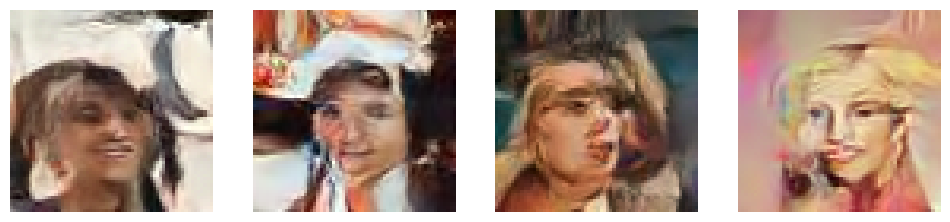

In [ ]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer

import matplotlib.pyplot as plt


model = ConvSODEUNet(n_steps=1000)

diffusion = GaussianDiffusion(
    model,
    image_size = 64,
    timesteps = 1000,           # number of steps
    sampling_timesteps = 256    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
)

trainer = Trainer(
    diffusion,
    #"trainingSet/trainingSet/",
    #"PetImages/Cat",
    #"cifar10/train",
    #"celeba_hq_256",
    "img_align_celeba",
    train_batch_size = 128,
    train_lr =2e-4, #8e-5,
    train_num_steps = 10000, #700000, # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.9999, # 0.995       # exponential moving average decay
    amp = True,                       # turn on mixed precision
    calculate_fid = False             # whether to calculate fid during training
)

trainer.train()

sampled_images = diffusion.sample(batch_size = 4)
sampled_images = sampled_images.to("cpu")

# Plot the images
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(sampled_images[i].permute(1, 2, 0))
    axs[i].axis('off')

# Display the plot
plt.show()

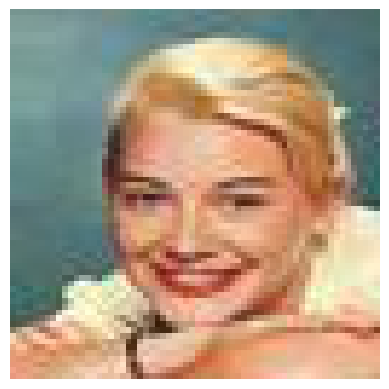

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = "img_align_celeba/135013.jpg"

# Load the image using PIL
image = Image.open(image_path)

# Display the image using plt.imshow()
plt.imshow(image)
plt.axis('off')  # Remove axis ticks and labels
plt.show()

In [ ]:
import numpy as np

np.asarray(image).shape

(64, 64, 3)

In [ ]:
!ls img_align_celeba

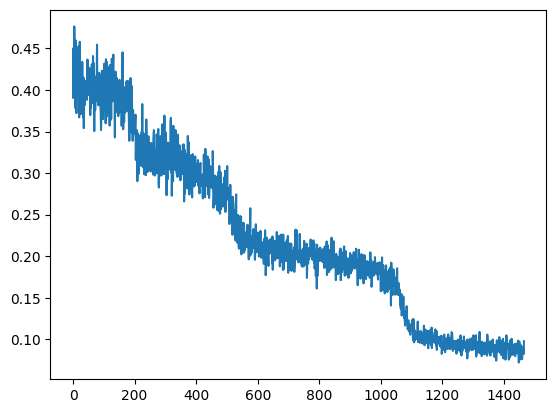

In [ ]:
# Load and plot loss curve:
import pickle

# Reading the list of losses from the file
with open('losses.pkl', 'rb') as file:
    losses = pickle.load(file)

# Now you have the losses list and you can work with it
plt.plot(np.arange(0, len(losses), 1), losses)
plt.show()

In [ ]:
sample_image = diffusion.sample(batch_size = 1)
plt.imshow(sample_image[0].permute(1, 2, 0))

  0%|          | 0/7000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

training complete


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

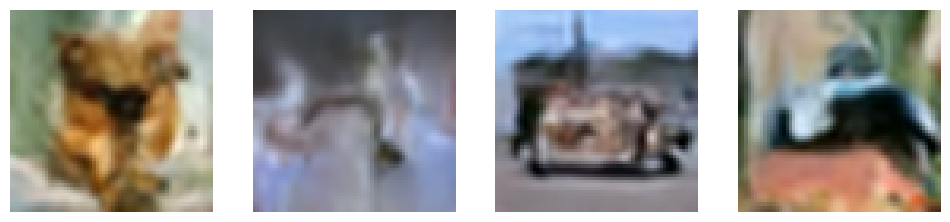

In [ ]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Lambda, Resize
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)

diffusion = GaussianDiffusion(
    model,
    image_size = 64,
    timesteps = 1000,           # number of steps
    sampling_timesteps = 250    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
)

trainer = Trainer(
    diffusion,
    "cifar10/train",
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 7000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
    calculate_fid = False              # whether to calculate fid during training
)

trainer.train()

sampled_images = diffusion.sample(batch_size = 4)
sampled_images = sampled_images.to("cpu")

# Plot the images
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(sampled_images[i].permute(1, 2, 0))
    axs[i].axis('off')

# Display the plot
plt.show()

### Load the saved model with the custom method in Trainer

In [ ]:
# Load the desired model
milestone = 10  # Specify the milestone or identifier of the saved model
trainer.load(milestone)

# Access the loaded model
loaded_model = trainer.model

loading from version 1.8.3


In [ ]:
total_timesteps = 1000
sampling_timesteps = 32
times = torch.linspace(0, total_timesteps - 1, steps = sampling_timesteps).to(torch.int32)
x = torch.randn(1, 3, 32, 32)
loaded_model = loaded_model.cpu()

sample_image = diffusion.sample(batch_size = 1)
plt.imshow(sample_image[0].permute(1, 2, 0))

# Trained with noise

In [ ]:
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion

#model = Unet(
#    dim = 64,
#    dim_mults = (1, 2, 4, 8)
#)
model = ConvSODEUNet(n_steps=1000)

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000    # number of steps
)

training_images = torch.rand(8, 3, 128, 128) # images are normalized from 0 to 1
loss = diffusion(training_images)
loss.backward()
# after a lot of training

sampled_images = diffusion.sample(batch_size = 4)
sampled_images.shape # (4, 3, 128, 128)

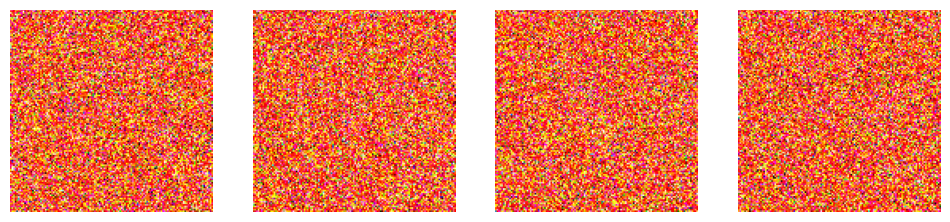

In [ ]:
import matplotlib.pyplot as plt

# Plot the images
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(sampled_images[i].permute(1, 2, 0))
    axs[i].axis('off')

# Display the plot
plt.show()

# Quality evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn.functional as F
from torchvision import transforms, utils
from torchvision.io import read_image
from torchvision.utils import save_image
import pandas as pd
from PIL import Image
import numpy as np
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torchdiffeq")


# Function to calculate PSNR
def psnr(mse, max_val=1.0):
    return 10 * math.log10(max_val**2 / mse)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained model
checkpoint = torch.load('model-374.pt')

# This is where you might need to figure out how to extract just the model's state_dict
model_state_dict = checkpoint['model']
new_state_dict = {k.replace('model.', ''): v for k, v in model_state_dict.items() if k.startswith('model.')}

model = ConvSODEUNet(n_steps=1000)  # Make sure this is your model's class
model = model.to(device)
model.load_state_dict(new_state_dict)
model.eval()

# Define your dataset and dataloader
transform = transforms.Compose([transforms.ToTensor()])
full_dataset = datasets.ImageFolder(root='cifar10/test', transform=transform)
dataloader = DataLoader(full_dataset, batch_size=1, shuffle=False)

# Time
total_timesteps = 1000
sampling_timesteps = 256

times = torch.linspace(0, total_timesteps - 1, steps = sampling_timesteps).to(torch.int32)

# Metrics data list
data = []
output_dir = "denoised_images"
os.makedirs(output_dir, exist_ok=True)

# Noise standard deviation
noise_std = 0.1

# Loop through dataset
for idx, image in enumerate(dataloader):
    if idx >= 50:
        break

    image = image[0]
    # Add noise to image
    noisy_image = image + noise_std * torch.randn_like(image)

    # Pass image through the model
    with torch.no_grad():
        outputs = model(noisy_image.to(device), times.to(device))
        outputs = outputs.cpu()

    # Calculate metrics
    mse_value = mean_squared_error(image.numpy().flatten(), outputs.numpy().flatten())
    psnr_value = 10 * np.log10(1 / mse_value)
    ssim_value = ssim(image.numpy().transpose(0, 2, 3, 1)[0], outputs.numpy().transpose(0, 2, 3, 1)[0], channel_axis=2)

    # Save images
    save_image(image, os.path.join(output_dir, f"image_{idx}_original.png"))
    save_image(noisy_image, os.path.join(output_dir, f"image_{idx}_noisy.png"))
    save_image(outputs, os.path.join(output_dir, f"image_{idx}_denoised.png"))

    # Add metrics to data list
    data.append({"MSE": mse_value, "PSNR": psnr_value, "SSIM": ssim_value})

# Create a DataFrame from the data
metrics_df = pd.DataFrame(data)

warnings.filterwarnings("default", category=UserWarning, module="torchdiffeq")

# Print the DataFrame
metrics_df

1. Make it work with celebA (64x64)
2. CelebA 64x64 seems to be getting the shape of the head much better than 256x256 celeba-hq model. Might be because of the position of the attention within the model? Try to move the attention of the celeba-64 model to the middle layer and see if anything changes.
3. Use pretrained model from colab in HPC, milestone 10. Prepare the code to handle that.
4. Check if the fact that for each downsampling and upsampling blocks there are **2 ResNet blocks** is important.

* Check **initialisation**
* **Implement denoising** - I don't understand what's the difference (basic idea is to condition the denoising with a validation image and then compare it to the output of the denoising model. But changing the reverse process/sampling??).
* Track **inference time** for the same number of steps
* Check if **less denoising steps** are required for cUNet
* Compare **quality metrics** for denoising
---------------------------------------------------
* Increase **batch size** and check if it's a big difference. **(DONE: Now batch size 128)**
* Change **learning rate** to the one given in the DDPM paper (2e-4 - 2e-5 for 256x256 images). **(DONE)**
* Test a more appropriate **time embedding** **(DONE: Using dim 256 like original UNet)**
* Changed **conv_2 layer in convSODEFunc** to from kernel size 1 to 3 and padding 0 to 1. **(DONE)**
* Implemented **contribution** skip connections, residual, and time embedding naturally into ODEBlock. **(DONE)**
* Check if **attention is properly implemented** in cUNet. **(DONE: it seems that in the official implementation for the UNet there is one attention layer for each downsampling and upsampling block as well as in the bottleneck)**
* Check if model is being **saved appropriately.** **(DONE: had to use the the load method built in Trainer class)**
* **Track training loss** **(DONE: tracking the average loss every 1000 training steps and saving it as a pickle file)**
* Add **data augmentations** (random horizontal flips). Paper claims that it improves sample quality slightly. **(DONE: codebase already includes data augmentations)**
* Get rid of self.te_1 **(DONE)**
* Check modifications required to train the diffusion model with **CelebA HQ.** -> 6 feature map resolutions (instead of 4), batch size = 64, sampling timesteps (?) to 128, 0.5M training steps, learning rate to 2e10-5. **(DONE)**

# Download the data and preprocess it

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  55.2M      0  0:00:14  0:00:14 --:--:-- 57.1M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip

In [ ]:
!ls PetImages/Cat

In [ ]:
!rm -r PetImages readme[1].txt CDLA-Permissive-2.0.pdf

### Resizing images

In [ ]:
from PIL import Image
import os

#input_folders = ["train/daisy", "train/dandelion", "train/rose", "train/rose",
#                 "train/sunflower", "train/tulip"]
#input_folders = ["cifar10/train/airplane", "cifar10/train/automobile",
                #  "cifar10/train/bird", "cifar10/train/cat",
                #  "cifar10/train/deer", "cifar10/train/dog",
                #  "cifar10/train/frog", "cifar10/train/horse",
                #  "cifar10/train/ship", "cifar10/train/truck"]
input_folders = ["img_align_celeba"]


output_size = (64, 64)

for input_folder in input_folders:
    # Delete the Thumbs.db file if it exists
    thumbs_db_path = os.path.join(input_folder, "Thumbs.db")
    if os.path.exists(thumbs_db_path):
        os.remove(thumbs_db_path)

    for filename in os.listdir(input_folder):
        file_path = os.path.join(input_folder, filename)

        # Check if it is a file (and not a directory)
        if os.path.isfile(file_path):
            try:
                # Open the image
                with Image.open(file_path) as im:
                    # Verify the image
                    im.verify()

                # Check if the image size matches the target size
                im = Image.open(file_path)
                image_size = im.size
                if image_size != output_size:
                    # Resize the image
                    im_resized = im.resize(output_size, Image.ANTIALIAS)

                    # Save the resized image back to the original file
                    im_resized.save(file_path)

            except:
                # If an error is thrown, it's probably a bad image, delete it
                print(f"Deleting corrupted image: {file_path}")
                #os.remove(file_path)

print("Images have been processed")

Images have been processed


In [ ]:
import os
from PIL import Image

folder_path = "cifar10/train/airplane"

# Get a list of image file names in the folder
image_names = os.listdir(folder_path)

# Choose a random image from the list
random_image_name = image_names[10]  # Change this line to select a different random image

# Construct the path to the random image
random_image_path = os.path.join(folder_path, random_image_name)

# Open the image using PIL
image = Image.open(random_image_path)

# Get the size of the image
image_size = image.size

print(f"Image size: {image_size}")

Image size: (64, 64)


### Delete corrupted and != 3 channel images

In [ ]:
from PIL import Image
import os

input_folders = ["train/daisy", "train/dandelion", "train/rose", "train/rose",
                 "train/sunflower", "train/tulip"]

for folder in input_folders:
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)

        # Check if it is a file (and not a directory)
        if os.path.isfile(file_path):
            try:
                # Open the image
                with Image.open(file_path) as im:
                    # Verify the image
                    im.verify()

            except:
                # If an error is thrown, it's probably a bad image, delete it
                print(f"Deleting corrupted image: {file_path}")
                os.remove(file_path)

print("Corrupted images have been deleted")

In [ ]:
from PIL import Image
import numpy as np
import os

input_folders = ["img_align_celeba"]
target_size = (64, 64, 3)

for input_folder in input_folders:
    for filename in os.listdir(input_folder):
        file_path = os.path.join(input_folder, filename)

        # Check if it is a file (and not a directory)
        if os.path.isfile(file_path):
            # Check if the image size matches the target size
            img_np = np.asarray(Image.open(file_path)).shape

            if img_np != target_size:
                # Delete the image if it doesn't have the target size
                print(f"Deleting image with incorrect size: {file_path}")
                os.remove(file_path)

print("Incorrectly sized images have been deleted")

Incorrectly sized images have been deleted


### Count images in the folder

In [ ]:
import os

#folder_path = "PetImages/Cat"
folder_path = "img_align_celeba"

# Get the list of image file names in the folder
image_names = os.listdir(folder_path)

# Count the number of image files
num_images = len(image_names)

print("Number of images in the folder:", num_images)

# Normally 12500 - should be 12470

Number of images in the folder: 202599


# Download MNIST as JPG

In [ ]:
# Gotta upload kaggle.json
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d scolianni/mnistasjpg

In [ ]:
!unzip mnistasjpg.zip

In [ ]:
!kaggle datasets download -d imsparsh/flowers-dataset

In [ ]:
!unzip flowers-dataset.zip

In [ ]:
# Download cifar10 dataset
!kaggle datasets download -d oxcdcd/cifar10

In [ ]:
!unzip cifar10.zip

In [ ]:
# Download celebA-HQ dataset
!kaggle datasets download -d badasstechie/celebahq-resized-256x256

In [ ]:
!unzip celebahq-resized-256x256.zip

In [ ]:
!rm -r testSample trainingSet mnistasjpg.zip testSet.tar.gz trainingSet.tar.gz testSample testSet trainingSample

In [ ]:
!kaggle datasets download -d ahmedshawaf/celeba

100% 1.32G/1.32G [01:10<00:00, 21.3MB/s]
100% 1.32G/1.32G [01:10<00:00, 20.0MB/s]


In [ ]:
!unzip celeba.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/197600.jpg  
  inflating: img_align_celeba/197601.jpg  
  inflating: img_align_celeba/197602.jpg  
  inflating: img_align_celeba/197603.jpg  
  inflating: img_align_celeba/197604.jpg  
  inflating: img_align_celeba/197605.jpg  
  inflating: img_align_celeba/197606.jpg  
  inflating: img_align_celeba/197607.jpg  
  inflating: img_align_celeba/197608.jpg  
  inflating: img_align_celeba/197609.jpg  
  inflating: img_align_celeba/197610.jpg  
  inflating: img_align_celeba/197611.jpg  
  inflating: img_align_celeba/197612.jpg  
  inflating: img_align_celeba/197613.jpg  
  inflating: img_align_celeba/197614.jpg  
  inflating: img_align_celeba/197615.jpg  
  inflating: img_align_celeba/197616.jpg  
  inflating: img_align_celeba/197617.jpg  
  inflating: img_align_celeba/197618.jpg  
  inflating: img_align_celeba/197619.jpg  
  inflating: img_align_celeba/197620.jpg  
  inflating: img_align_celeba/197621.jpg  
  i

In [ ]:
!rm celeba.zip